<a href="https://colab.research.google.com/github/iliavrtn/final-project/blob/main/classification_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Required Libraries
This cells installs and imports all the necessary packages to ensure the environment is properly set up.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install datasets
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system

In [4]:
# Standard library
import os
import re
import glob

# NLTK
import nltk
from nltk import word_tokenize, pos_tag, ngrams
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Data analysis & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    confusion_matrix,
    pairwise_distances
)
from sklearn.metrics.cluster import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)

# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# XLNet
import torch

from datasets import Dataset, DatasetDict
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn_extra.cluster import KMedoids

# Initialize NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# Preprocess Data
This cell calls `preprocess_data(BASE_DIR, VERSION)` to handle data preparation.

**Key steps inside `preprocess_data`:**
- Load or lemmatize dictionaries.
- Verify if preprocessed data already exists.
- Process text files per category and field:
  - Clean, tokenize, lemmatize, and identify domain terms.
  - Replace domain terms with `<TERM>` and remove non-Oxford words.
- Assemble processed texts and labels into a DataFrame.
- Encode labels numerically.
- Split text into chunks if necessary.

**Output:** A segmented DataFrame with preprocessed texts and labels.

## Lemmatizer Initialization

**Lemmatizer:** Initializes `WordNetLemmatizer` for normalizing words to their base forms.

In [5]:
lemmatizer = WordNetLemmatizer()

## Helper Functions

This section includes utility functions to assist in preprocessing tasks:

### `get_wordnet_pos(treebank_tag)`
Maps Penn Treebank POS tags to WordNet POS tags to improve lemmatization accuracy.  
- Supports Noun, Verb, Adjective, and Adverb tags; defaults to Noun for others.
- Ensures correct base forms are generated during lemmatization.

---

### `chunk_text(text, max_length=510)`
Splits a text into smaller chunks with a maximum length of `max_length` tokens.  
- Useful for processing long texts in manageable segments.

---

### `replace_phrases(txt, phrases, replacer)`
Replaces specific phrases in a text with a given replacement string:  
1. Sorts phrases by length (longest first) to prevent partial replacements.
2. Escapes special regex characters for literal matching.
3. Uses regex with word boundaries for accurate phrase substitution.

In [6]:
def get_wordnet_pos(treebank_tag):
    """
    Map Penn Treebank POS tags (e.g., 'NN', 'VB', 'JJ', 'RB') to the
    corresponding WordNet POS tags (NOUN, VERB, ADJ, ADV).
    This is crucial for accurate lemmatization with WordNetLemmatizer,
    because passing the correct POS helps get the correct base form of a word.

    WordNet generally focuses on four primary parts of speech for lemmatization,
    so we provide POS tags for Noun, Verb, Adjective, Adverb, and all other
    tags will be Noun.

    Some links:
    https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [7]:
def chunk_text(text, max_length=510):
    """
    Splits a given text into smaller chunks, each containing up to max_length number of tokens.
    """
    words = text.split()
    return [' '.join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

In [8]:
def replace_phrases(txt, phrases, replacer):
    """
    1) Sort phrases by the number of words (longest first) to prevent partial replacements.
    2) Escape special regex characters in phrases to match them literally.
    3) Construct a regex pattern with word boundaries to match whole phrases.
    4) Perform the substitution using the compiled pattern.
    """
    phrases = sorted(phrases, key=lambda x: len(x.split()), reverse=True)
    pattern = r'\b(' + r'|'.join(re.escape(phrase) for phrase in phrases) + r')\b'
    return re.sub(pattern, replacer, txt)

## Text Preprocessing and Domain Term Normalization

### `preprocess_text(file_path, domain_terms, oxford_words)`
Processes a text file by cleaning, lemmatizing, and normalizing terms, ensuring consistency and removing unnecessary content.

**Steps:**
1. **Read File:** Reads the file content; logs an error and returns `None` if the file is missing.
2. **Initial Cleaning:**
   - Converts text to lowercase.
   - Removes non-alphabetic characters.
   - Filters out short words (≤1 character).
   - Normalizes spaces.
3. **Tokenization and Lemmatization:**
   - Tokenizes the text.
   - Assigns POS tags and converts each word to its base form using `WordNetLemmatizer`.
4. **N-Gram Generation:**
   - Creates 1-grams, 2-grams, and 3-grams to identify domain-specific multi-word terms.
5. **Domain Term Replacement:**
   - Replaces identified domain terms with `<TERM>`.
   - Removes words not found in the Oxford dictionary.
6. **Final Output:** Returns cleaned and processed text ready for analysis.

**Purpose:** This function prepares raw text for downstream tasks like clustering or classification by standardizing its structure and content.

In [9]:
def preprocess_text(file_path, domain_terms, oxford_words):
    """
    Process a text file to extract lemmatized terms.
    Returns processed text or None if the file doesn't exist.
    """
    # Attempt to read the original text file. If the file doesn't exist, log an error and return None.
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found.")
        return None

    # 1) Convert to lowercase
    # 2) Remove all non-alphabetic characters
    # 3) Filter out very short words
    # 4) Normalize spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    text = ' '.join(word for word in text.split() if len(word) > 1)
    text = re.sub(r'\s+', ' ', text).strip()

    # 1) Split the cleaned text and tokenize (word_tokenize)
    # 2) Assign POS tags to each token (pos_tag)
    # 3) Convert each word to its base form (lemmatizer.lemmatize)
    # 4) Maps the Treebank POS tag to a WordNet POS category (get_wordnet_pos)
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags
    ]
    lemmatized_text = ' '.join(lemmatized_words)

    # Generate 1-grams, 2-grams, and 3-grams to identify multi-word domain terms
    onegram = list(ngrams(lemmatized_words, 1))
    bigrams = list(ngrams(lemmatized_words, 2))
    trigrams = list(ngrams(lemmatized_words, 3))

    # Build sets of n-grams that need to be replaced or deleted.

    # Set of single words not found in the Oxford dictionary.
    onegram_oxford_strings_to_delete = {
        " ".join(g) for g in onegram if " ".join(g) not in oxford_words
    }

    # Set of domain terms (1-,2-,3-gram) that should be replaced with a placeholder <TERM>.
    trigram_domain_strings_to_delete = {
        " ".join(t) for t in trigrams if " ".join(t) in domain_terms
    }
    bigram_domain_strings_to_delete = {
        " ".join(b) for b in bigrams if " ".join(b) in domain_terms
    }
    onegram_domain_strings_to_delete = {
        " ".join(g) for g in onegram if " ".join(g) in domain_terms
    }

    all_domain_phrases = (trigram_domain_strings_to_delete
                          | bigram_domain_strings_to_delete
                          | onegram_domain_strings_to_delete)

    # Replace all domain terms with <TERM>
    lemmatized_text = re.sub(
        r'\s+',
        ' ',
        replace_phrases(lemmatized_text, all_domain_phrases, '<TERM>')
    ).strip()
    # Replace all words which not from dictionary with ''
    final_text = re.sub(
        r'\s+',
        ' ',
        replace_phrases(lemmatized_text, onegram_oxford_strings_to_delete, '')
    ).strip()
    # Return text after all "cleaning"
    return final_text

## DataFrame Creation and Text Chunking Functions

This section defines two functions essential for organizing and segmenting preprocessed text data.

---

### `create_and_encode_dataframe(all_texts, all_labels)`
- Combines preprocessed texts and their labels into a pandas DataFrame.
- Encodes string labels into numeric IDs using `LabelEncoder`, ensuring compatibility with machine learning models.
- Outputs:
  - A DataFrame with text, label, and corresponding `label_id`.
  - A mapping of labels to their numeric IDs for reference.

---

### `segment_texts_into_chunks(data_df, max_length)`
- Splits each text in the DataFrame into smaller chunks using the `chunk_text` function.
- Assigns the same `label_id` to all chunks derived from a single text.
- Outputs:
  - A DataFrame with segmented texts and their numeric labels.
  - Facilitates processing and analysis of large texts by breaking them into manageable pieces.


In [10]:
def create_and_encode_dataframe(all_texts, all_labels):
    # -----------------------------------------------------------------------------
    # CREATING AND ENCODING THE DATAFRAME
    # -----------------------------------------------------------------------------
    # - Combine all preprocessed texts and their corresponding labels into a pandas DataFrame.
    # - Each row represents a single preprocessed text and its associated label.
    # - Encode categorical labels into numerical IDs using LabelEncoder:
    #     - All rows with the same label receive the same label_id.
    #     - This numerical encoding is essential for compatibility with machine learning models.
    #
    # Structure of 'data' DataFrame:
    #   | text                                 | label        | label_id |
    #   |--------------------------------------|--------------|----------|
    #   | "Text sample for CS Automata..."     | "CS_AUTOMATA"| 0        |
    #   | "Text sample for MATH Calculus..."   | "MATH_CALC"  | 1        |
    #   | "CS OS text..."                      | "CS_OS"      | 2        |
    #   | "More CS Automata content..."        | "CS_AUTOMATA"| 0        |
    #
    # -----------------------------------------------------------------------------

    # Assemble the final texts and labels into a pandas DataFrame
    print("Creating DataFrame...")
    data_df = pd.DataFrame({'text': all_texts, 'label': all_labels})
    # Encode the string labels into numeric IDs
    # LabelEncoder scans the 'label' column to identify unique labels and assigns a unique integer to each.
    # All rows with the same label receive the same label_id.
    label_encoder = LabelEncoder()
    data_df['label_id'] = label_encoder.fit_transform(data_df['label'])
    print(f"DataFrame created with {len(data_df)} samples.")
    # We create a separate DataFrame to display the mapping between labels and label_ids
    # Example of 'label_mapping' DataFrame:
    #   | label        | label_id |
    #   |--------------|----------|
    #   | "CS_AUTOMATA" | 0        |
    #   | "CS_OS"       | 1        |
    #   | "MATH_CALC"   | 2        |
    #   | "MATH_PROB"   | 3        |
    label_mapping = pd.DataFrame({
      'label': label_encoder.classes_,
      'label_id': range(len(label_encoder.classes_))
    })
    print("Label to ID Mapping:")
    print(label_mapping)

    return data_df

In [11]:
def segment_texts_into_chunks(data_df, max_length):
    # -----------------------------------------------------------------------------
    # SEGMENTING TEXTS INTO CHUNKS
    # -----------------------------------------------------------------------------
    # - Iterate over each preprocessed text (row) in the DataFrame.
    # - Split each text into smaller chunks using the 'chunk_text' function.
    # - Assign the same 'label_id' to all chunks derived from the same original text.
    #
    # Resulting 'segmented_data' DataFrame Structure:
    #   | text                                     | label_id |
    #   |------------------------------------------|----------|
    #   | "This is the first chunk of text..."     | 0        |
    #   | "This is the second chunk of text..."    | 0        |
    #   | "Another text begins here..."            | 1        |
    #   | "Continuing the second text segment..."  | 1        |
    # -----------------------------------------------------------------------------
    print("Segmenting texts...")
    segmented_texts, segmented_labels = [], []
    for _, row in data_df.iterrows():
        segments = chunk_text(row['text'], max_length=max_length)
        segmented_texts.extend(segments)
        segmented_labels.extend([row['label_id']] * len(segments))

    print(f"Segmented {len(segmented_texts)} text samples.")
    segmented_data = pd.DataFrame({'text': segmented_texts, 'label_id': segmented_labels})

    # The final output is a DataFrame of text segments with numeric labels.
    return segmented_data

## Main Preprocessing Function: `preprocess_data(BASE_DIR, VERSION)`

This function orchestrates the entire text preprocessing workflow, including dictionary lemmatization, text file processing, and creating a segmented DataFrame.

**Key Steps:**
1. **Setup Directories:**
   - Defines paths for dictionaries and preprocessed data storage.
   - Checks if preprocessed data already exists for reuse.

2. **Dictionary Lemmatization:**
   - Reads and lemmatizes domain-specific (CS, Math) and general English (Oxford) dictionaries for consistency.

3. **Category and Field Processing:**
   - Iterates through defined categories (`CS`, `MATH`) and their respective fields (e.g., `AUTOMATA`, `LINALG`).
   - For each text file:
     - If preprocessed data exists, load it.
     - Otherwise, preprocess the file (cleaning, tokenization, lemmatization).

4. **DataFrame Creation:**
   - Combines all processed texts and their labels into a DataFrame.
   - Encodes string labels into numeric IDs using `LabelEncoder`.

5. **Text Segmentation:**
   - Splits long texts into smaller chunks for analysis (default chunk size: 256 tokens).

**Output:** A segmented DataFrame containing preprocessed text chunks and numeric labels, ready for machine learning or clustering tasks.

In [12]:
def preprocess_data(BASE_DIR, VERSION):
    """
    Main function to orchestrate reading dictionaries, processing text,
    and returning the final segmented DataFrame.
    """
    # Create a path to store/read preprocessed data for this version
    PROCESSED_BASE_DIR = os.path.join(
        os.path.dirname(BASE_DIR),
        f"TXT_BOOKS_{VERSION}"
    )

    # Locate the necessary dictionary files for domain-specific and general English words
    CS_DICT_PATH = os.path.join(BASE_DIR, 'cs.txt')
    MATH_DICT_PATH = os.path.join(BASE_DIR, 'math.txt')
    OXFORD_DICT_PATH = os.path.join(BASE_DIR, 'oxford.txt')

    # Read each dictionary file and store the lines in lists
    # Line in each dictionary contains term/word
    # Convert all terms to lowercase for uniformity
    print("Processing dictionaries...")
    with open(CS_DICT_PATH, 'r', encoding='utf-8') as f:
        cs_words = [term.lower() for term in f.read().splitlines()]

    with open(MATH_DICT_PATH, 'r', encoding='utf-8') as f:
        math_words = [term.lower() for term in f.read().splitlines()]

    with open(OXFORD_DICT_PATH, 'r', encoding='utf-8') as f:
        oxford_words = [term.lower() for term in f.read().splitlines()]

    # -----------------------------------------------------------------------------
    # LEMMATIZING DICTIONARY WORDS
    # -----------------------------------------------------------------------------
    # We iterate over each term from the CS, MATH, and OXFORD dictionaries to:
    # 1) Tokenize via word_tokenize (NLTK): split the term into individual tokens
    #    (e.g., "computer science" -> ["computer", "science"]).
    # 2) POS (Part of Speech) tag via pos_tag (NLTK): assign part-of-speech tags
    #    (e.g., ("computer", "NN"), ("science", "NN")).
    #     some tags examples: NN: noun, common, singular or mass | VB: verb, base form | JJ: adjective or numeral, ordinal | ...
    # 3) Lemmatize via lemmatizer (nltk.stem): convert each token to its base form
    #    using WordNet (e.g., "studies" -> "study").
    #    - We use get_wordnet_pos() to map Treebank tags (NN, VB, etc.)
    #      to WordNet POS tags (NOUN, VERB, etc.).
    # 4) Re-join multi-word phrases: if a term has multiple words, we join them back
    #    (e.g., "computer science").
    # 5) Store all results in a set: to remove duplicates and for fast membership checks later.
    #
    # The purpose is to ensure consistency between how we handle domain terms
    # and general English words. It also helps match domain-specific multi-word phrases
    # in the book texts, which will also be lemmatized.

    # word_tokenize:
    #  - Splits text into tokens using more than just whitespace.
    #  - Handles punctuation and contractions (e.g., "don't" -> ["do", "n't"]).

    # pos_tag:
    #  - Assigns part-of-speech tags (NN, VB, JJ, etc.) using a pretrained model
    #  - Considers both the word itself and its context to infer the best tag.

    # lemmatizer.lemmatize:
    # 1. Takes a word and its POS tag as inputs.
    # 2. Looks up the lemma in the WordNet database based on the POS.
    # 3. Returns the base form of the word. If not found, returns the word unchanged.
    # -----------------------------------------------------------------------------

    print("Lemmatizing CS dictionary...")
    lemmatized_cs_words = {
        " ".join(
            lemmatizer.lemmatize(w, get_wordnet_pos(p))
            for w, p in pos_tag(word_tokenize(cs_word))
        )
        for cs_word in cs_words
    }

    print("Lemmatizing MATH dictionary...")
    lemmatized_math_words = {
        " ".join(
            lemmatizer.lemmatize(w, get_wordnet_pos(p))
            for w, p in pos_tag(word_tokenize(math_word))
        )
        for math_word in math_words
    }

    print("Lemmatizing OXFORD dictionary...")
    lemmatized_oxford_words = {
        " ".join(
            lemmatizer.lemmatize(w, get_wordnet_pos(p))
            for w, p in pos_tag(word_tokenize(oxford_word))
        )
        for oxford_word in oxford_words
    }

    # Two primary categories (CS, MATH), each with multiple fields
    CATEGORIES = {
        "CS": ["AUTOMATA", "COMPILER", "OOP", "OS", "FPROG", "DSA"],
        "MATH": ["LINALG", "ABSALG", "CALC", "COMBI", "PROB", "LOGIC", "SETTHEORY"]
    }

    all_texts, all_labels = [], []

    # If we've previously processed and saved the data for this version,
    # we can load it directly. Otherwise, we create the folders and process again.
    use_preprocessed = os.path.exists(PROCESSED_BASE_DIR)

    if use_preprocessed:
        print(f"Version '{VERSION}' found. Using preprocessed files...")
    else:
        print(f"Version '{VERSION}' not found. Creating and preprocessing files...")
        os.makedirs(PROCESSED_BASE_DIR, exist_ok=True)

    # Process each category and field
    for category, fields in CATEGORIES.items():
        for field in fields:
            original_folder_path = os.path.join(BASE_DIR, category, field)
            processed_folder_path = os.path.join(PROCESSED_BASE_DIR, category, field)
            if not use_preprocessed:
                os.makedirs(processed_folder_path, exist_ok=True)
            # Collect all pathes to original text files of specific category and field
            text_files = glob.glob(os.path.join(original_folder_path, "*.txt"))
            # Here we decide which domain dictionary to use: CS or MATH.
            domain_terms = (
                lemmatized_cs_words if category == "CS" else lemmatized_math_words
            )
            # For each original text file should be processed file
            for file_path in text_files:
                processed_file_path = os.path.join(processed_folder_path,
                                                   os.path.basename(file_path))

                if use_preprocessed:
                    # Load preprocessed file if it exists
                    if not os.path.exists(processed_file_path):
                        print(f"Preprocessed file {processed_file_path} not found, skipping.")
                        continue
                    with open(processed_file_path, 'r', encoding='utf-8') as pf:
                        # Read the processed text for specific category and field
                        processed_text = pf.read().strip()
                else:
                    # Call 'preprocess_text()' to clean, tokenize, lemmatize, etc.
                    print(f"Processing file: {file_path}")
                    processed_text = preprocess_text(
                        file_path,
                        domain_terms,
                        lemmatized_oxford_words
                    )
                    # Save newly processed text for future reuse
                    if processed_text:
                        with open(processed_file_path, 'w', encoding='utf-8') as pf:
                            pf.write(processed_text)

                if processed_text:
                    # Add a proccesed text accordingly with a label
                    all_texts.append(processed_text)
                    all_labels.append(f"{category}_{field}")

    # Create and encode the DataFrame
    data_df = create_and_encode_dataframe(all_texts, all_labels)

    # Segment the texts into smaller chunks
    # Changing the value of max_length change the size of chunk
    segmented_data = segment_texts_into_chunks(data_df, max_length=256)

    # The final output is a DataFrame of text segments with numeric labels.
    return segmented_data

# Clustering

## KMeans

In [13]:
def save_clustering_results(results_file_path: str, results_str: str):
    """
    Saves clustering results to a file.
    """
    if results_file_path is not None:
        with open(results_file_path, 'a', encoding='utf-8') as f:
            f.write(results_str)
    print(results_str)

In [14]:

def run_kmeans_clustering_with_doc2vec(segmented_data, vector_array, results_file_path=None, k=14, **kwargs):
    """
    Runs K-Means clustering on the given segmented DataFrame using Doc2Vec embeddings,
    performs PCA to reduce to 3 dimensions, and visualizes the results and confusion matrix.

    Parameters:
        - segmented_data: DataFrame containing 'text' and 'label_id'
        - vector_array: Array of Doc2Vec embeddings
        - results_file_path (str): Path to save clustering results
        - k (int): Number of clusters
        - **kwargs: Additional parameters for Doc2Vec

    Returns:
        - cluster_labels (ndarray): Cluster assignments for each segment
    """
    print("\033[32m\n======================\n\033[0m")
    print("\033[32mRunning KMeans clustering with Doc2Vec...\033[0m")
    print("\033[32m\n======================\n\033[0m")

    texts = segmented_data['text'].tolist()
    true_labels = segmented_data['label_id'].tolist()

    # Step 1: K-Means Clustering
    print(f"Clustering into {k} clusters using K-Means...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(vector_array)
    print("K-Means clustering complete.")

    # Step 2: PCA for Visualization (3D)
    print("Performing PCA for dimensionality reduction to 3 components...")
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(vector_array)
    print("Dimensionality reduction complete. Plotting K-Means clusters in 3D...")

    # 3D Plot for Predicted Clusters
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    palette = sns.color_palette('tab20', 13)
    cmap = ListedColormap(palette)
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                         c=cluster_labels, cmap=cmap, alpha=0.8, s=49, edgecolors='w')
    ax.set_title("K-Means Clusters of Text Data (PCA 3D Projection)")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    handles, _ = scatter.legend_elements()
    ax.legend(handles, [f"Cluster {i}" for i in range(k)], title="Clusters")
    plt.show()

    # 3D Plot for Actual Labels
    if true_labels is not None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter2 = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                              c=true_labels, cmap=cmap, alpha=0.8, s=49, edgecolors='w')
        ax.set_title("Actual Labels of Text Data (PCA 3D Projection)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        unique_true = sorted(set(true_labels))
        handles2, _ = scatter2.legend_elements()
        ax.legend(handles2, [f"Cluster {l}" for l in unique_true], title="True Label")
        plt.show()

    # Step 3: Compute Clustering Evaluation Metrics
    silhouette = silhouette_score(vector_array, cluster_labels, metric='manhattan')
    ari = adjusted_rand_score(true_labels, cluster_labels)
    ami = adjusted_mutual_info_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    hom = homogeneity_score(true_labels, cluster_labels)
    com = completeness_score(true_labels, cluster_labels)
    v = v_measure_score(true_labels, cluster_labels)

    results_str = (
        "\n======================\n"
        "K-Means Clustering with Doc2Vec Results\n"
        "\n======================\n"
        f"Number of Clusters (k): {k}\n\n"
        f"Adjusted Rand Index (ARI): {ari:.4f}\n"
        f"Adjusted Mutual Information (AMI): {ami:.4f}\n"
        f"Normalized Mutual Information (NMI): {nmi:.4f}\n"
        f"Homogeneity: {hom:.4f}\n"
        f"Completeness: {com:.4f}\n"
        f"V-measure: {v:.4f}\n"
        f"Silhouette Score: {silhouette:.4f}\n\n"
    )
    save_clustering_results(results_file_path, results_str)

    print("\033[32m\n======================\n\033[0m")
    print("\033[32mRunning KMeans clustering finished.\033[0m")
    print("\033[32m\n======================\n\033[0m")

    return cluster_labels


## PAM

In [15]:

def run_pam_clustering_with_doc2vec(segmented_data, vector_array, results_file_path=None, k=14, **kwargs):
    """
    Runs PAM clustering (via KMedoids from scikit-learn-extra) on the given
    segmented DataFrame using Doc2Vec embeddings, performs PCA for 3 dimensions,
    and visualizes the results including a confusion matrix.

    Args:
        - segmented_data (pd.DataFrame): DataFrame containing 'text' and 'label_id'.
        - vector_array (np.ndarray): Array of Doc2Vec embeddings.
        - results_file_path (str): Optional path to save results to a file.
        - k (int): Number of clusters.
        - **kwargs: Additional parameters for Doc2Vec.

    Returns:
        - cluster_labels (np.ndarray): Cluster assignments for each document.
    """

    print("\033[32m\n======================\n\033[0m")
    print("\033[32mRunning PAM clustering with Doc2Vec...\033[0m")
    print("\033[32m\n======================\n\033[0m")

    # Step 1: Prepare data
    texts = segmented_data['text'].tolist()
    true_labels = segmented_data['label_id'].tolist()

    # Step 2: PAM clustering using KMedoids with the 'pam' method
    print(f"Clustering into {k} clusters using KMedoids (PAM) with eucledian metric...")
    kmed = KMedoids(
        n_clusters=k,
        metric="euclidean",
        method='pam',
        init='build',
        max_iter=300,
        random_state=42
    )
    kmed.fit(vector_array)
    cluster_labels = kmed.labels_
    medoids = kmed.medoid_indices_
    print("PAM clustering complete.")
    print("Selected medoid indices:", medoids)

    # Step 3: PCA for Visualization (3D)
    print("Performing PCA for dimensionality reduction to 3 components...")
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(vector_array)
    print("Dimensionality reduction complete. Plotting PAM clusters in 3D...")

    # 3D Plot for Predicted Clusters
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    palette = sns.color_palette('tab20', 13)
    cmap = ListedColormap(palette)
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        c=cluster_labels, cmap=cmap, alpha=0.8, s=49, edgecolors='w'
    )
    ax.set_title("PAM Clusters of Text Data (PCA 3D Projection)")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    handles, _ = scatter.legend_elements()
    ax.legend(handles, [f"Cluster {i}" for i in range(k)], title="Clusters")
    plt.show()

    # 3D Plot for Actual Labels
    if true_labels is not None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter2 = ax.scatter(
            X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
            c=true_labels, cmap=cmap, alpha=0.8, s=49, edgecolors='w'
        )
        ax.set_title("Actual Labels of Text Data (PCA 3D Projection)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        handles2, _ = scatter2.legend_elements()
        unique_true = sorted(set(true_labels))
        ax.legend(handles2, [f"Cluster {l}" for l in unique_true], title="True Label")
        plt.show()

    # Step 4: Compute Clustering Evaluation Metrics
    print("Evaluating clustering performance...")
    silhouette = silhouette_score(vector_array, cluster_labels, metric='euclidean')
    calinski = calinski_harabasz_score(vector_array, cluster_labels)
    davies = davies_bouldin_score(vector_array, cluster_labels)

    results_str = (
        "\n======================\n"
        "PAM Clustering with Doc2Vec Results\n"
        f"\nNumber of clusters (k): {k}"
        f"\nDistance metric: Euclidean"
        f"\nSilhouette Score: {silhouette:.4f}"
        f"\nDavies-Bouldin Index: {davies:.4f}"
        f"\nCalinski-Harabasz Index: {calinski:.4f}\n"
    )
    save_clustering_results(results_file_path, results_str)

    print("\033[32m\n======================\n\033[0m")
    print("\033[32mRunning PAM clustering finished.\033[0m")
    print("\033[32m\n======================\n\033[0m")

    return cluster_labels

## DBSCAN

In [16]:

def run_dbscan_clustering_with_doc2vec(segmented_data, vector_array, results_file_path=None,
                                       eps=0.5, min_samples=5, distance_metric='cosine', **kwargs):
    """
    Runs DBSCAN clustering on the given segmented DataFrame using Doc2Vec,
    performs PCA to reduce to 3 dimensions, visualizes the results via 3D scatter plots,
    and computes evaluation metrics.

    Parameters:
        - segmented_data: DataFrame containing 'text' and optionally 'label_id'
        - vector_array: Array of Doc2Vec embeddings
        - results_file_path: Optional path to save results to a file
        - eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        - min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.
        - distance_metric (str): The metric to use when calculating distance ('cosine', 'euclidean', etc.)
        - **kwargs: Additional parameters for Doc2Vec.

    Returns:
        - cluster_labels (ndarray): Array of cluster assignments for each sample.
    """
    print("\033[32m\n======================\n\033[0m")
    print("\033[32mRunning DBSCAN clustering with Doc2Vec...\033[0m")
    print("\033[32m\n======================\n\033[0m")

    # Step 1: Prepare data
    texts = segmented_data['text'].tolist()
    true_labels = segmented_data.get('label_id', None)

    print(f"Doc2Vec vectorization complete. Shape of document embeddings: {vector_array.shape}")
    if distance_metric == 'cosine':
        vector_array = normalize(vector_array)

    # Step 2: DBSCAN Clustering
    print(f"Clustering with DBSCAN using eps={eps}, min_samples={min_samples}, metric={distance_metric}...")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=distance_metric, n_jobs=-1)
    cluster_labels = dbscan.fit_predict(vector_array)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    print(f"DBSCAN found {n_clusters} clusters with {n_noise} noise points.")

    # Step 3: PCA for Visualization (3D)
    print("Performing PCA for dimensionality reduction to 3 components...")
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(vector_array)
    print("PCA complete. Plotting DBSCAN clusters in 3D...")

    # 3D Plot for Predicted Clusters
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    palette = sns.color_palette('tab20', 13)
    cmap = ListedColormap(palette)
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        c=cluster_labels, cmap=cmap, alpha=0.8, s=49, edgecolors='w'
    )
    ax.set_title(f"DBSCAN Clusters (eps={eps}, min_samples={min_samples}, metric={distance_metric})")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    handles, _ = scatter.legend_elements()
    unique_clusters = sorted(set(cluster_labels))
    ax.legend(handles, [f"Cluster {i}" for i in unique_clusters], title="Clusters")
    plt.show()

    # 3D Plot for Actual Labels
    if true_labels is not None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter2 = ax.scatter(
            X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
            c=true_labels, cmap=cmap, alpha=0.8, s=49, edgecolors='w'
        )
        ax.set_title("Actual Labels of Text Data (PCA 3D Projection)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        handles2, _ = scatter2.legend_elements()
        unique_true = sorted(set(true_labels))
        ax.legend(handles2, [f"Cluster {l}" for l in unique_true], title="True Label")
        plt.show()

    # Step 4: Compute Clustering Evaluation Metrics
    silhouette, calinski, davies = None, None, None
    if true_labels is not None and len(set(cluster_labels)) > 1:
        print("\nComputing clustering evaluation metrics...")
        silhouette = silhouette_score(vector_array, cluster_labels, metric=distance_metric)
        calinski = calinski_harabasz_score(vector_array, cluster_labels)
        davies = davies_bouldin_score(vector_array, cluster_labels)
    else:
        print("Skipping evaluation metrics due to lack of true labels or single cluster scenario.")

    results_str = (
        "\n======================\n"
        "DBSCAN Clustering with Doc2Vec Results\n"
    )
    if silhouette is not None and calinski is not None and davies is not None:
        results_str += (
            f"\nSilhouette Score: {silhouette:.4f}"
            f"\nDavies-Bouldin Index: {davies:.4f}"
            f"\nCalinski-Harabasz Index: {calinski:.4f}"
        )
    save_clustering_results(results_file_path, results_str)

    print("\033[32m\n======================\n\033[0m")
    print("\033[32mRunning DBSCAN clustering finished.\033[0m")
    print("\033[32m\n======================\n\033[0m")

    return cluster_labels

## Gaussian Mixture Models

In [17]:
def run_gmm_clustering_with_doc2vec(segmented_data, vector_array, results_file_path=None, max_components=15, **kwargs):
    """
    Runs Gaussian Mixture Model (GMM) clustering on the given segmented DataFrame using Doc2Vec embeddings.
    Uses BIC and AIC to determine the optimal number of components (clusters).

    Parameters:
        - segmented_data: DataFrame containing 'text' and 'label_id'.
        - vector_array: Array of Doc2Vec embeddings.
        - results_file_path: Optional path to save results to a file.
        - max_components: Maximum number of components to evaluate for BIC/AIC.
        - **kwargs: Additional parameters for Doc2Vec.

    Returns:
        - optimal_gmm: Fitted GMM model with the optimal number of components.
        - cluster_labels: Cluster assignments for each document.
    """
    print("\033[32m\n======================\n\033[0m")
    print("\033[32mRunning GMM clustering with Doc2Vec...\033[0m")
    print("\033[32m\n======================\n\033[0m")

    # Step 1: Prepare data
    texts = segmented_data['text'].tolist()
    true_labels = segmented_data.get('label_id', None)

    # Step 2: Determine Optimal Number of Components (BIC/AIC)
    print("Determining optimal number of components using BIC and AIC...")
    bic_scores = []
    aic_scores = []
    silhouette_scores = []
    gmms = []

    for n_components in range(2, max_components + 1):
        print(f"Evaluating GMM with {n_components} components...")
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(vector_array)
        gmms.append(gmm)

        bic = gmm.bic(vector_array)
        aic = gmm.aic(vector_array)
        bic_scores.append(bic)
        aic_scores.append(aic)

        # Compute silhouette score for the current number of components
        labels = gmm.predict(vector_array)
        silhouette = silhouette_score(vector_array, labels) if n_components > 1 else -1
        silhouette_scores.append(silhouette)

    # Plot BIC and AIC Scores
    plt.figure(figsize=(10, 6))
    x_vals = range(2, max_components + 1)
    plt.plot(x_vals, bic_scores, label='BIC', marker='o')
    plt.plot(x_vals, aic_scores, label='AIC', marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.title('BIC and AIC Scores for GMM')
    plt.legend()
    plt.grid()
    plt.show()

    # Step 3: Select Optimal Number of Components (based on minimum BIC)
    optimal_n_components = np.argmin(bic_scores) + 2  # since our loop starts at 2
    print(f"Optimal number of components based on BIC: {optimal_n_components}")

    # Step 4: Fit GMM with Optimal Components
    print(f"Fitting GMM with {optimal_n_components} components...")
    optimal_gmm = gmms[optimal_n_components - 2]
    cluster_labels = optimal_gmm.predict(vector_array)

    # Step 5: Visualize Clusters using PCA (3D)
    print("Performing PCA for dimensionality reduction to 3 components for visualization...")
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(vector_array)
    print("PCA complete. Plotting GMM clusters in 3D...")

    # 3D Plot for Predicted Clusters
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    palette = sns.color_palette('tab20', 13)
    cmap = ListedColormap(palette)
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        c=cluster_labels, cmap=cmap, alpha=0.8, s=49, edgecolors='w'
    )
    ax.set_title(f"GMM Clusters of Text Data (Optimal Components: {optimal_n_components})")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    handles, _ = scatter.legend_elements()
    unique_clusters = sorted(set(cluster_labels))
    ax.legend(handles, [f"Cluster {i}" for i in unique_clusters], title="Clusters")
    plt.show()

    # 3D Plot for Actual Labels (if available)
    if true_labels is not None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter2 = ax.scatter(
            X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
            c=true_labels, cmap=cmap, alpha=0.8, s=49, edgecolors='w'
        )
        ax.set_title("Actual Labels of Text Data (PCA 3D Projection)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        handles2, _ = scatter2.legend_elements()
        unique_true = sorted(set(true_labels))
        ax.legend(handles2, [f"Label {l}" for l in unique_true], title="True Label")
        plt.show()

        # Confusion Matrix Visualization
        cm_df = pd.crosstab(pd.Series(true_labels, name="Actual Label"),
                            pd.Series(cluster_labels, name="Predicted Label"))
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
        plt.title("Confusion Matrix (True Class vs. Cluster)")
        plt.ylabel("Actual Label")
        plt.xlabel("Predicted Label")
        plt.show()

    # Step 6: Evaluate Clustering Performance
    print("Evaluating clustering performance...")
    silhouette = silhouette_score(vector_array, cluster_labels)
    calinski = calinski_harabasz_score(vector_array, cluster_labels)
    davies = davies_bouldin_score(vector_array, cluster_labels)

    results_str = (
        "\n======================\n"
        "GMM Clustering with Doc2Vec Results\n"
        f"\nOptimal Number of Components: {optimal_n_components}"
        f"\nSilhouette Score: {silhouette:.4f}"
        f"\nDavies-Bouldin Index: {davies:.4f}"
        f"\nCalinski-Harabasz Index: {calinski:.4f}\n"
    )
    save_clustering_results(results_file_path, results_str)

    print("\033[32m\n======================\n\033[0m")
    print("\033[32mRunning GMM clustering finished.\033[0m")
    print("\033[32m\n======================\n\033[0m")

    return optimal_gmm, cluster_labels


# XLNET

In [18]:
def run_xlnet_classification(segmented_data, results_file_path=None, model_path=None):
    """
    Splits data into train/val/test sets, trains XLNet model, and evaluates performance.
    Also provides confusion matrix, class distributions, classification report,
    and sample predictions with probability distributions.
    Parameters:
        - segmented_data: DataFrame containing 'text' and 'label_id'.
        - results_file_path: Optional path to save results to a file.
        - model_path: Optional path to load a pre-trained model from.

    Returns:
        - None
    """
    print("\033[32m\n======================\n\033[0m")
    print("\033[32mRunning XLNet model...\033[0m")
    print("\033[32m\n======================\n\033[0m")
    print("Splitting data into training, validation, and test sets...")
    # Split the data on train and temp 80\20
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        segmented_data['text'],
        segmented_data['label_id'],
        test_size=0.2,
        random_state=42
    )

    # Creating validation and test set by splitting the temp data equally
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts,
        temp_labels,
        test_size=0.5,
        random_state=42
    )

    print(f"Training samples: {len(train_texts)}")
    print(f"Validation samples: {len(val_texts)}")
    print(f"Test samples: {len(test_texts)}")

    # XLNet Preparation
    print("Preparing XLNet model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

    if model_path:
        # Load the model from the specified path
        print(f"Loading model from {model_path}...")
        model = XLNetForSequenceClassification.from_pretrained(model_path)
    else:
        # Initialize a new model
        print("Initializing new XLNet model...")
        model = XLNetForSequenceClassification.from_pretrained(
            'xlnet-base-cased',
            num_labels=len(segmented_data['label_id'].unique())
        )
    model.to(device)
    print("XLNet model ready.")

    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=512
        )

    # Create Hugging Face Datasets for train, validation, and test
    datasets = DatasetDict({
        'train': Dataset.from_dict({'text': train_texts, 'label': train_labels}),
        'validation': Dataset.from_dict({'text': val_texts, 'label': val_labels}),
        'test': Dataset.from_dict({'text': test_texts, 'label': test_labels}),
    }).map(tokenize_function, batched=True)

    datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predictions, average='weighted'
        )
        acc = accuracy_score(labels, predictions)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    # If a pre-trained model path is provided, skip training
    if model_path:
        print("Skipping training since a pre-trained model is provided.")
    else:
        print("Configuring training arguments...")
        training_args = TrainingArguments(
            output_dir='./results',
            evaluation_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            num_train_epochs=5,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=datasets['train'],
            eval_dataset=datasets['validation'],
            compute_metrics=compute_metrics,
        )

        # Training
        print("Starting XLNet training...")
        trainer.train()
        print("Training completed.")

    # Validation
    print("Evaluating model on validation set...")
    trainer = Trainer(
        model=model,
        eval_dataset=datasets['validation'],
        compute_metrics=compute_metrics
    )
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    # Test
    print("Predicting on test set...")
    predictions = trainer.predict(datasets['test'])
    test_pred = np.argmax(predictions.predictions, axis=-1)

    # Convert labels (torch tensors) to NumPy arrays
    true_labels = datasets['test']['label'].cpu().numpy()

    # ------------------------------
    # 2. Visualize Confusion Matrix
    # ------------------------------
    print("\n=== Confusion Matrix (Test) ===")
    conf_mat = confusion_matrix(true_labels, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    # -------------------------------------------
    # 3. Print How Many Samples Are Predicted for Each Class
    # -------------------------------------------
    print("\n=== Class Distribution: Predicted vs. True (Test) ===")
    unique_pred, counts_pred = np.unique(test_pred, return_counts=True)
    print("Predicted class distribution:")
    for cls, cnt in zip(unique_pred, counts_pred):
        print(f"  Class {cls}: {cnt} samples")

    unique_true, counts_true = np.unique(true_labels, return_counts=True)
    print("True class distribution:")
    for cls, cnt in zip(unique_true, counts_true):
        print(f"  Class {cls}: {cnt} samples")

    # ---------------------------------------
    # 4. Identify Classes the Model Struggles With
    # ---------------------------------------
    print("\n=== Detailed Classification Report (Test) ===")
    print(classification_report(true_labels, test_pred))

    # -------------------------------------------------
    # 5. Print Example Predictions with Probabilities
    # -------------------------------------------------
    print("\n=== Example Predictions with Probability Distributions ===")
    # Convert logits to probabilities using softmax
    probabilities = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

    # Pick a few random samples
    np.random.seed(42)
    indices = np.random.choice(len(probabilities), size=5, replace=False)

    for idx in indices:
        text_example = datasets['test']['text'][idx]
        true_label_sample = datasets['test']['label'][idx]
        pred_label = test_pred[idx]
        pred_probs = probabilities[idx]

        print("\nText Example (truncated):", text_example[:200], "...")
        print("True Label:", true_label_sample)
        print("Predicted Label:", pred_label)
        print("Probabilities:", np.round(pred_probs, 3))

    # Final Test Metrics
    print("\nCalculating test metrics...")
    test_acc = accuracy_score(true_labels, test_pred)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        true_labels, test_pred, average='weighted'
    )

    results_str = (
        "\n======================\n"
        "XLNet Results\n"
        f"\nTest Accuracy: {test_acc}"
        f"\nTest Precision: {test_precision}"
        f"\nTest Recall: {test_recall}"
        f"\nTest F1 Score: {test_f1}"
    )

    save_clustering_results(results_file_path, results_str)

# Doc2Vec Model

In [19]:
def run_doc2vec_model(segmented_data, path_to_save=None, **kwargs):
  """
  Create Doc2Vec model using TaggedData from gensim.models.doc2vec.
  Parameters:
        - segmented_data: DataFrame containing 'text' and 'label_id'.
        - path_to_save: Optional path to save the Doc2Vec model.
        - **kwargs: Additional parameters for Doc2Vec.
    Returns:
        - X: Array of Doc2Vec embeddings.
  """
  if path_to_save and os.path.exists(f"{path_to_save}/vectors.npy"):
    print(f"Using loaded np.array with pretrained Doc2Vec from {path_to_save}...")
    return np.load(f"{path_to_save}/vectors.npy")
  else:
    texts = segmented_data['text'].tolist()
    # Step 1: Prepare Doc2Vec TaggedDocuments
    print("Preparing data for Doc2Vec...")
    tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)])
                    for i, text in enumerate(texts)]

    # Step 2: Train Doc2Vec Model
    print("Training Doc2Vec model...")
    doc2vec_model = Doc2Vec(documents=tagged_data, **kwargs)
    print("Doc2Vec training complete.")

    # Step 3: Infer Vectors for Clustering
    print("Generating document embeddings...")
    X = np.array([doc2vec_model.infer_vector(text.split()) for text in texts])
    print(f"Generated embeddings with shape: {X.shape}")
    np.save(f"{path_to_save}/vectors.npy", X)
    print(f"Saved embeddings to {path_to_save}.")
    return X

# Main function of whole project

Processing dictionaries...
Lemmatizing CS dictionary...
Lemmatizing MATH dictionary...
Lemmatizing OXFORD dictionary...
Version 'v1.5_cleaned_irrelevant_pages_full_dictionaries' found. Using preprocessed files...
Creating DataFrame...
DataFrame created with 134 samples.
Label to ID Mapping:
             label  label_id
0      CS_AUTOMATA         0
1      CS_COMPILER         1
2           CS_DSA         2
3         CS_FPROG         3
4           CS_OOP         4
5            CS_OS         5
6      MATH_ABSALG         6
7        MATH_CALC         7
8       MATH_COMBI         8
9      MATH_LINALG         9
10      MATH_LOGIC        10
11       MATH_PROB        11
12  MATH_SETTHEORY        12
Segmenting texts...
Segmented 50147 text samples.


Running XLNet model...


Splitting data into training, validation, and test sets...
Training samples: 40117
Validation samples: 5015
Test samples: 5015
Preparing XLNet model...
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Loading model from /content/drive/MyDrive/🅰 Aleph - Capstone Project 2024/TXT_BOOKS_v1.5_cleaned_irrelevant_pages_full_dictionaries/xlnet-model...
XLNet model ready.


Map:   0%|          | 0/40117 [00:00<?, ? examples/s]

Map:   0%|          | 0/5015 [00:00<?, ? examples/s]

Map:   0%|          | 0/5015 [00:00<?, ? examples/s]

Skipping training since a pre-trained model is provided.
Evaluating model on validation set...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aleksandr-pitkin (aleksandr-pitkin-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Evaluation Results: {'eval_loss': 0.8446689248085022, 'eval_model_preparation_time': 0.0024, 'eval_accuracy': 0.8247258225324028, 'eval_f1': 0.8245667968267478, 'eval_precision': 0.825156944250674, 'eval_recall': 0.8247258225324028, 'eval_runtime': 502.9995, 'eval_samples_per_second': 9.97, 'eval_steps_per_second': 1.247}
Predicting on test set...

=== Confusion Matrix (Test) ===


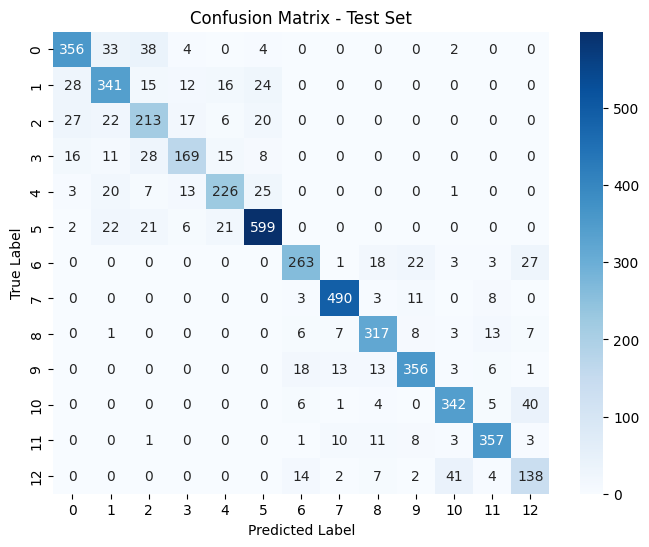


=== Class Distribution: Predicted vs. True (Test) ===
Predicted class distribution:
  Class 0: 432 samples
  Class 1: 450 samples
  Class 2: 323 samples
  Class 3: 221 samples
  Class 4: 284 samples
  Class 5: 680 samples
  Class 6: 311 samples
  Class 7: 524 samples
  Class 8: 373 samples
  Class 9: 407 samples
  Class 10: 398 samples
  Class 11: 396 samples
  Class 12: 216 samples
True class distribution:
  Class 0: 437 samples
  Class 1: 436 samples
  Class 2: 305 samples
  Class 3: 247 samples
  Class 4: 295 samples
  Class 5: 671 samples
  Class 6: 337 samples
  Class 7: 515 samples
  Class 8: 362 samples
  Class 9: 410 samples
  Class 10: 398 samples
  Class 11: 394 samples
  Class 12: 208 samples

=== Detailed Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       437
           1       0.76      0.78      0.77       436
           2       0.66      0.70      0.68       305
           3       0.7

In [20]:
"""
Main orchestration script: loads data, decides which clustering method
to use, runs the pipeline end-to-end, and trains XLNet.
"""



# Global config (customize as needed)
BASE_DIR = '/content/drive/MyDrive/🅰 Aleph - Capstone Project 2024/TXT_BOOKS_EDITED'
VERSION = "v1.5_cleaned_irrelevant_pages_full_dictionaries"
RESULTS_FILE_PATH = f'/content/drive/MyDrive/🅰 Aleph - Capstone Project 2024/RUN_RESULTS/results_{VERSION}.txt'

def main():

    # 1. Preprocessing
    segmented_data = preprocess_data(BASE_DIR, VERSION)

    # 2. Clustering
    # doc2vec_params = {
    #     'dm': 1,
    #     'vector_size': 128,
    #     'window': 5,
    #     'workers': 12,
    #     'epochs': 30,
    #     'dm_mean': 1,
    #     'min_count': 1
    # }

    # vector_array = run_doc2vec_model(segmented_data, path_to_save=f'/content/drive/MyDrive/🅰 Aleph - Capstone Project 2024/TXT_BOOKS_{VERSION}', **doc2vec_params)
    # try:
    #   run_kmeans_clustering_with_doc2vec(segmented_data, vector_array, results_file_path = RESULTS_FILE_PATH, k=13, **doc2vec_params)
    # except BaseException as e:
    #   print(f"\033[31mAn error occurred: {e}\n\033[0m")
    #   print("\033[31mBoberError was thrown. KMeans with Doc2Vec failed.\n\033[0m")
    # try:
    #   run_pam_clustering_with_doc2vec(segmented_data, vector_array, results_file_path = RESULTS_FILE_PATH, k=13, **doc2vec_params)
    # except BaseException as e:
    #   print(f"\033[31mAn error occurred: {e}\n\033[0m")
    #   print("\033[31mBoberError was thrown. PAM with Doc2Vec failed.\n\033[0m")
    # try:
    #   vector_array_dbscan = StandardScaler().fit_transform(vector_array)
    #   run_dbscan_clustering_with_doc2vec(
    #         segmented_data,
    #         vector_array,
    #         results_file_path = RESULTS_FILE_PATH,
    #         eps=0.593,
    #         min_samples=5,
    #         distance_metric='cosine'
    #     )
    # except BaseException as e:
    #   print(f"\033[31mAn error occurred: {e}\n\033[0m")
    #   print("\033[31mBoberError was thrown. DBSCAN with Doc2Vec failed.\n\033[0m")
    # try:
    #   run_gmm_clustering_with_doc2vec(segmented_data, vector_array, results_file_path = RESULTS_FILE_PATH, max_components=14, **doc2vec_params)
    # except BaseException as e:
    #   print(f"\033[31mAn error occurred: {e}\n\033[0m")
    #   print("\033[31mBoberError was thrown. GMM with Doc2Vec failed.\n\033[0m")

    # 3. XLNet Classification
    run_xlnet_classification(segmented_data, model_path='/content/drive/MyDrive/🅰 Aleph - Capstone Project 2024/TXT_BOOKS_v1.5_cleaned_irrelevant_pages_full_dictionaries/xlnet-model')


if __name__ == '__main__':
    main()